<a href="https://colab.research.google.com/github/torifinch/TravelUserSegmentation/blob/main/TravelTideProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TravelTide Project

Masterschool DA Course Mastery Project
Author: Victoria Finch

Date: 10.04.2025

###Purpose:

Segment users on the TravelTide website for targeted marketing.

- Deliver customized email rewards based on group characteristics.

###Considerations:

What does the business want to achieve?

- sdaa

What's the time range and scope of the dataset?

- Filter users that have more than 7 website sessions after 01/04/2023

###Deliverables:

- Problem statement
- Business goal
- Data goal
- Modeling approach
  - PCA for Dimensionality Reduction
  - Clustering using K-Means



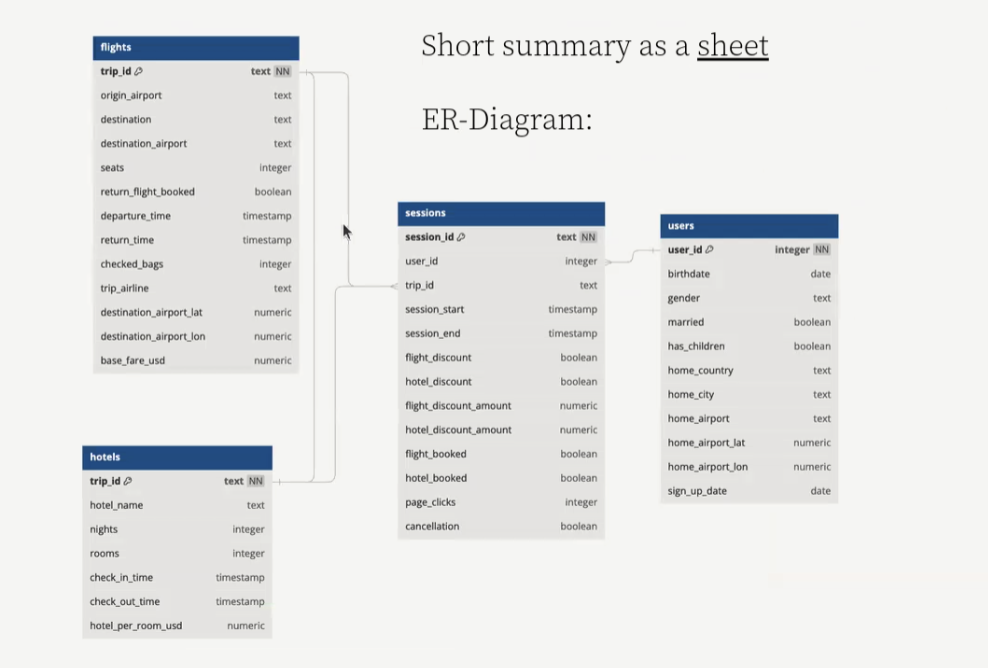

#Import Libraries

In [ ]:
#EDA
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime

#Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

#Machine Learning
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

#Load Data

Data was split using SQL:
- Sessions after 01/04/2023
- Users with more than 7 sessions in that period



```
WITH sessions_filter AS (
SELECT *
FROM sessions
WHERE session_start >= '2023-01-05'
 ),
final_user_pool AS (
SELECT user_id, COUNT(session_id) AS session_count
FROM users
LEFT JOIN sessions_filter
USING (user_id)
GROUP BY 1
HAVING COUNT(*) > 7
)
SELECT *
FROM final_user_pool
```
5782 filtered users


In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_users = pd.read_csv('/content/drive/MyDrive/Datasets/TravelTide/users.csv')

In [ ]:
df_sessions = pd.read_csv('/content/drive/MyDrive/Datasets/TravelTide/sessions.csv')

In [ ]:
df_flights = pd.read_csv('/content/drive/MyDrive/Datasets/TravelTide/flights.csv')

In [ ]:
df_hotels = pd.read_csv('/content/drive/MyDrive/Datasets/TravelTide/hotels.csv')

#EDA

###Users:

In [ ]:
df_users.shape

(5782, 11)

In [ ]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           5782 non-null   int64  
 1   birthdate         5782 non-null   object 
 2   gender            5782 non-null   object 
 3   married           5782 non-null   bool   
 4   has_children      5782 non-null   bool   
 5   home_country      5782 non-null   object 
 6   home_city         5782 non-null   object 
 7   home_airport      5782 non-null   object 
 8   home_airport_lat  5782 non-null   float64
 9   home_airport_lon  5782 non-null   float64
 10  sign_up_date      5782 non-null   object 
dtypes: bool(2), float64(2), int64(1), object(6)
memory usage: 418.0+ KB


In [ ]:
# Count nulls
df_users.isna().sum()

,0
user_id,0
birthdate,0
gender,0
married,0
has_children,0
home_country,0
home_city,0
home_airport,0
home_airport_lat,0
home_airport_lon,0


In [ ]:
df_users.duplicated().sum()

np.int64(0)

Creating an age column to make it easier to analyze

In [ ]:
# Create User Age Column
df_users['age'] = (datetime.now() - pd.to_datetime(df_users['birthdate'])).dt.days / 365.25 #leap years
df_users['age'] = df_users['age'].astype(int)  # Convert age to integers

df_users.head()

,user_id,birthdate,gender,married,has_children,home_country,home_city,home_airport,home_airport_lat,home_airport_lon,sign_up_date,age
0,531931,1984-05-26,F,False,False,usa,san jose,SJC,37.362,-121.929,2023-01-15,40
1,611065,1981-08-20,F,False,False,usa,los angeles,LAX,33.942,-118.408,2023-02-22,43
2,586762,1987-09-26,F,False,False,canada,montreal,YUL,45.468,-73.741,2023-02-11,37
3,229330,1976-11-08,F,True,False,usa,colorado springs,COS,38.806,-104.700,2022-06-27,48
4,536035,1995-11-09,M,False,False,usa,new york,LGA,40.777,-73.872,2023-01-17,29


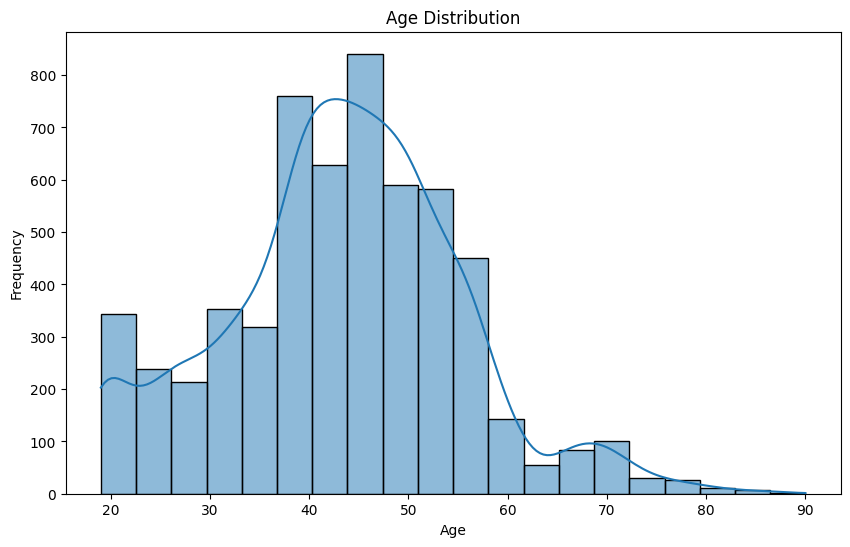

In [ ]:
# Age histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_users['age'], bins=20, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

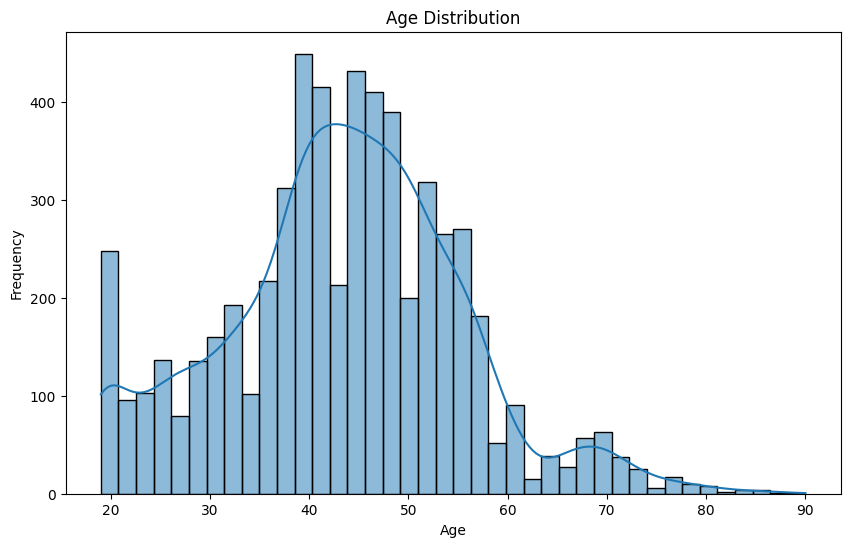

In [ ]:
# Age histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_users['age'], bins=40, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

I've increased the bins in the histogram to see there is a significant amount of users at the age 18/19. This could be attributed to students travelling after High School graduation or for their gap year.

There is also a bump in users at retirement age.

In [ ]:
# Group ages
df_users['age_group'] = pd.cut(df_users['age'], bins=[0, 18, 25, 35, 45, 55, 65, 100], labels=['0-18', '19-25', '26-35', '36-45', '46-55', '56-65', '66+'])
df_users['age_group'].value_counts()

,count
age_group,
36-45,1992
46-55,1667
26-35,877
56-65,444
19-25,408
66+,241
0-18,153


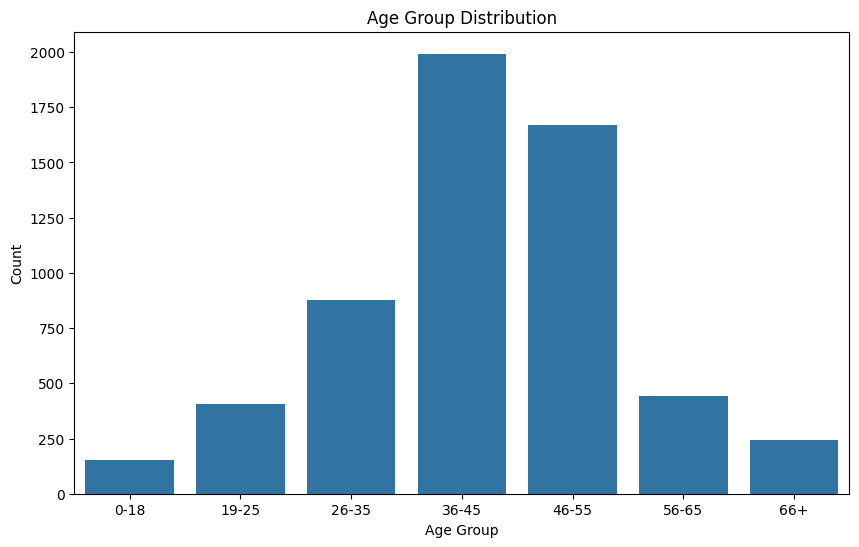

In [ ]:
# Age Group Distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df_users, x='age_group')
plt.title('Age Group Distribution')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.show()

In [ ]:
# Married Distribution
df_users['married'].value_counts()

,count
married,
False,3226
True,2556


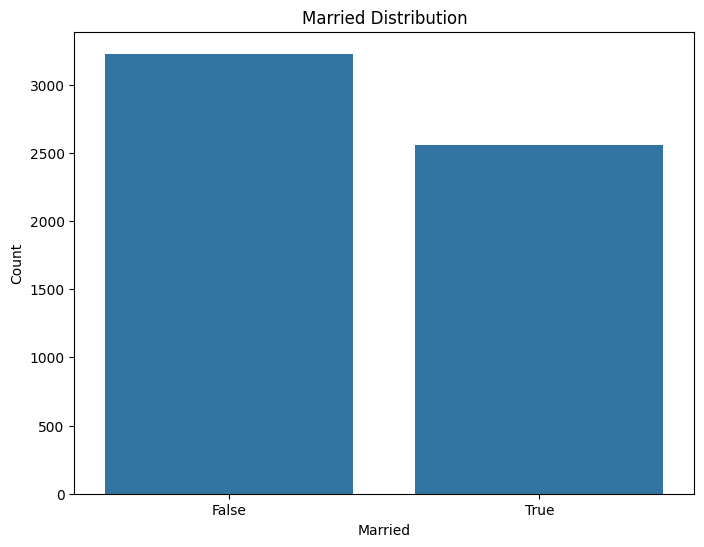

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df_users, x='married')
plt.title('Married Distribution')
plt.xlabel('Married')
plt.ylabel('Count')
plt.show()

In [ ]:
# Has Children Distribution
df_users['has_children'].value_counts()

,count
has_children,
False,3896
True,1886


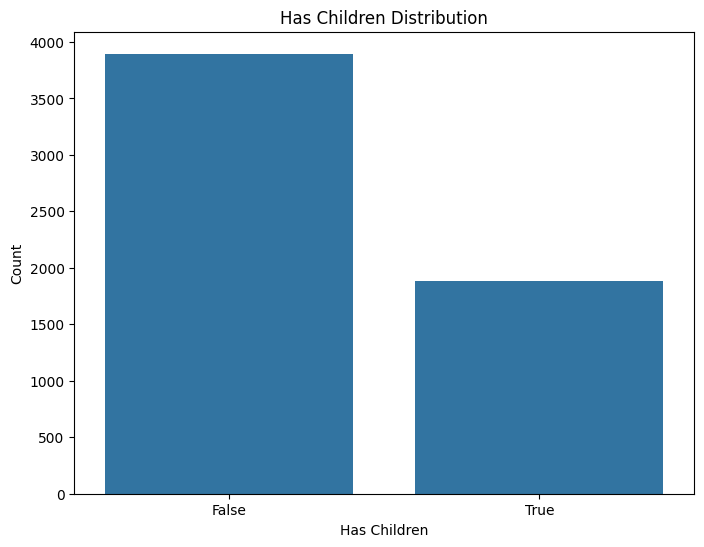

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df_users, x='has_children')
plt.title('Has Children Distribution')
plt.xlabel('Has Children')
plt.ylabel('Count')
plt.show()

In [ ]:
# Has Children x Married
pd.crosstab(df_users['married'], df_users['has_children'])

has_children,False,True
married,,
False,2386,840
True,1510,1046


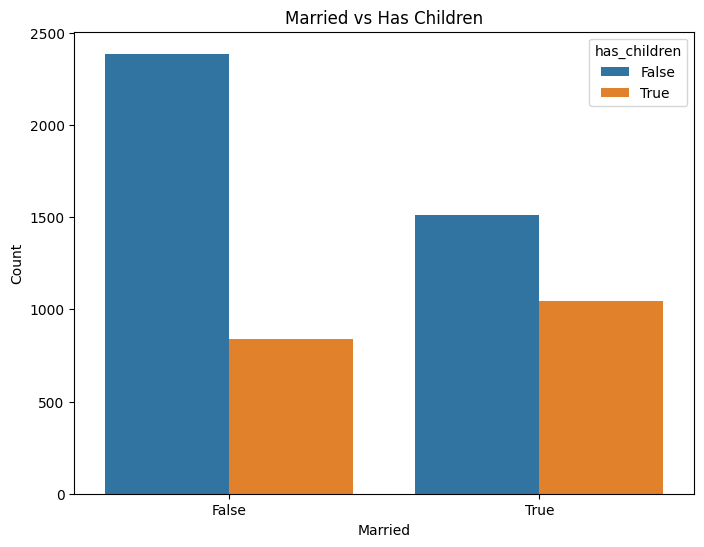

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df_users, x='married', hue='has_children')
plt.title('Married vs Has Children')
plt.xlabel('Married')
plt.ylabel('Count')
plt.show()

In [ ]:
# Gender distribution
df_users['gender'].value_counts()

,count
gender,
F,5118
M,653
O,11


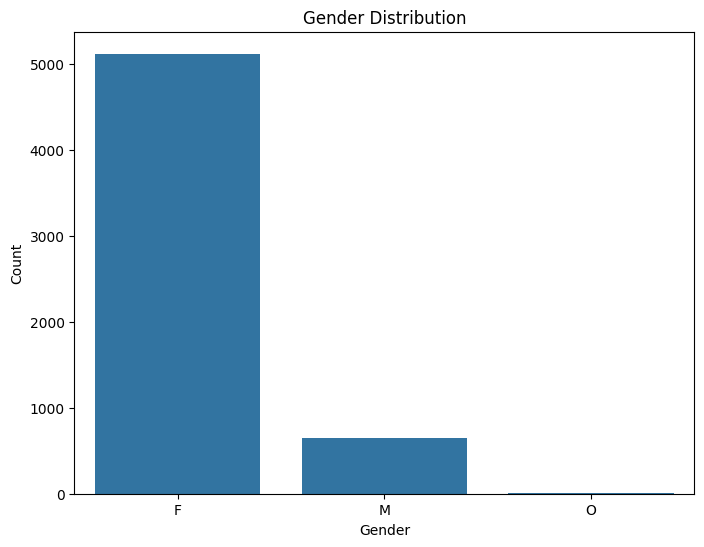

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df_users, x='gender')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

In the Gender Distribution, Female Users greatly outnumber the Male and Other Categories.

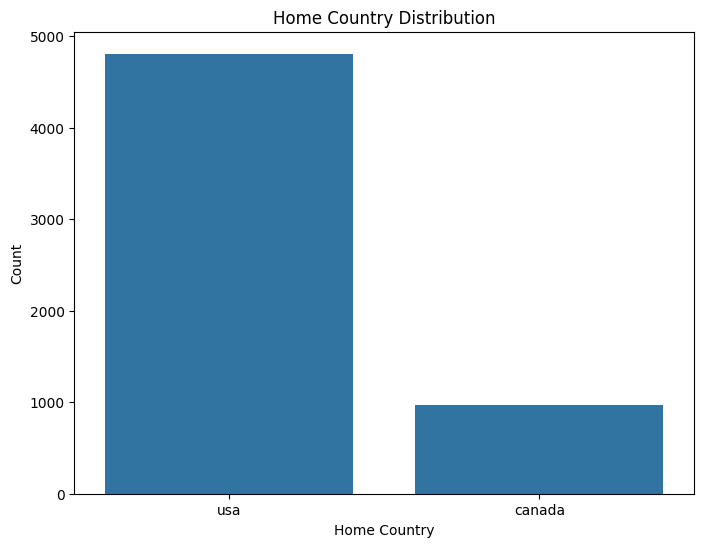

In [ ]:
# Home Country
plt.figure(figsize=(8, 6))
sns.countplot(data=df_users, x='home_country')
plt.title('Home Country Distribution')
plt.xlabel('Home Country')
plt.ylabel('Count')
plt.show()

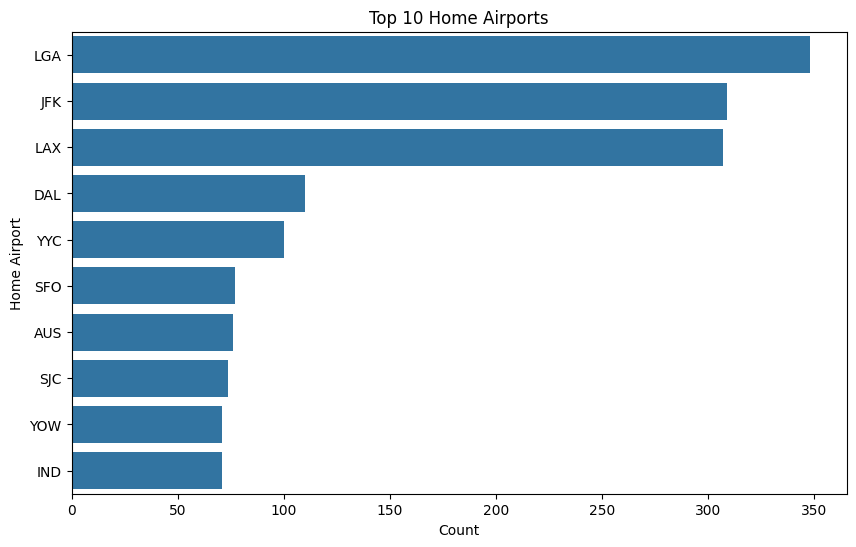

In [ ]:
# Top 10 Home airports
plt.figure(figsize=(10, 6))
sns.countplot(data=df_users, y='home_airport', order=df_users['home_airport'].value_counts().head(10).index)
plt.title('Top 10 Home Airports')
plt.xlabel('Count')
plt.ylabel('Home Airport')
plt.show()

The Top 3 Home Airports being located in highly-populated US cities New York and Los Angelos makes sense. YYC is located in Calgary, Canada and is the 3rd most populated city behind Toronto and Montreal that didn't make the list.

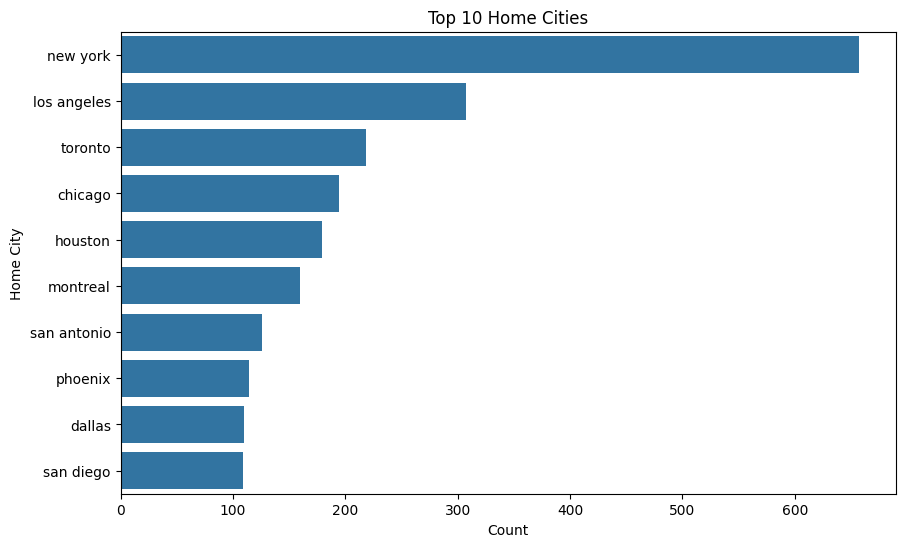

In [ ]:
# Top 10 Home Cities
plt.figure(figsize=(10, 6))
sns.countplot(data=df_users, y='home_city', order=df_users['home_city'].value_counts().head(10).index)
plt.title('Top 10 Home Cities')
plt.xlabel('Count')
plt.ylabel('Home City')
plt.show()

In [ ]:
# Create Months on Site Column
current_date = pd.to_datetime('now')
df_users['months_on_site'] = (current_date - pd.to_datetime(df_users['sign_up_date'])).dt.days // 30
df_users.head()

,user_id,birthdate,gender,married,has_children,home_country,home_city,home_airport,home_airport_lat,home_airport_lon,sign_up_date,age,age_group,months_on_site
0,531931,1984-05-26,F,False,False,usa,san jose,SJC,37.362,-121.929,2023-01-15,40,36-45,27
1,611065,1981-08-20,F,False,False,usa,los angeles,LAX,33.942,-118.408,2023-02-22,43,36-45,25
2,586762,1987-09-26,F,False,False,canada,montreal,YUL,45.468,-73.741,2023-02-11,37,36-45,26
3,229330,1976-11-08,F,True,False,usa,colorado springs,COS,38.806,-104.700,2022-06-27,48,46-55,33
4,536035,1995-11-09,M,False,False,usa,new york,LGA,40.777,-73.872,2023-01-17,29,26-35,27


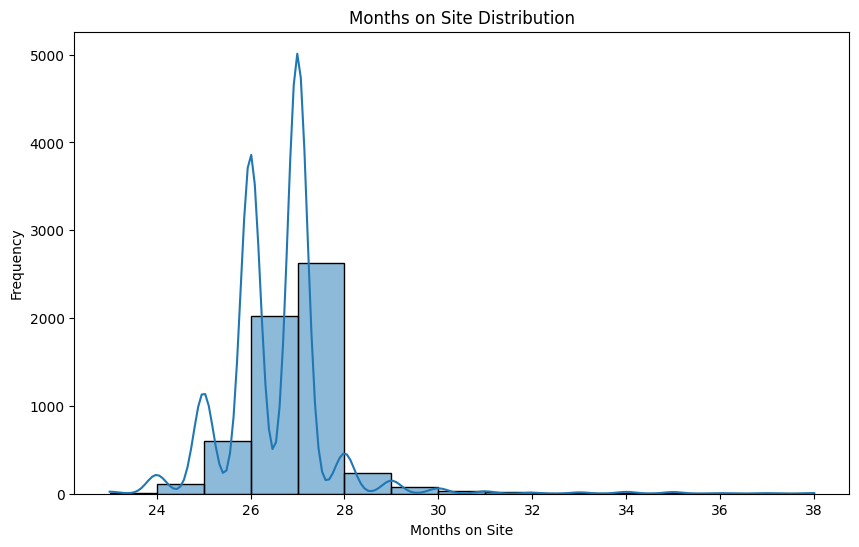

In [ ]:
# Months on Site Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_users['months_on_site'], bins=15, kde=True)
plt.title('Months on Site Distribution')
plt.xlabel('Months on Site')
plt.ylabel('Frequency')
plt.show()

###Flights

In [ ]:
df_flights.head()

,trip_id,origin_airport,destination,destination_airport,seats,return_flight_booked,departure_time,return_time,checked_bags,trip_airline,destination_airport_lat,destination_airport_lon,base_fare_usd
0,572396-98da506db3d94c80b194abc038a7d51a,MSN,calgary,YYC,1,True,2023-03-26 15:00:00,2023-03-30 15:00:00,0,Allegiant Air,51.114,-114.020,311.80
1,579829-5fe304c39c3e4b1584721fff699508fa,YYC,baltimore,BWI,1,True,2023-03-19 14:00:00,2023-03-23 14:00:00,1,AirTran Airways,39.175,-76.668,533.31
2,593350-e920794dbd694a8ab670580534fd6ddb,MHR,el paso,ELP,3,True,2023-03-20 14:00:00,2023-03-25 14:00:00,0,Allegiant Air,31.849,-106.380,807.74
3,252835-db62add9d6364162adc85cc234a12552,ORD,phoenix,PHX,1,True,2023-03-21 10:00:00,2023-03-27 10:00:00,1,American Airlines,33.535,-112.383,444.21
4,281952-e45eebaa33114910a96edc7e5f3b0a4f,LOU,new york,LGA,1,True,2023-03-20 07:00:00,2023-03-22 07:00:00,1,Delta Air Lines,40.640,-73.779,199.85


In [ ]:
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13767 entries, 0 to 13766
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   trip_id                  13767 non-null  object 
 1   origin_airport           13767 non-null  object 
 2   destination              13767 non-null  object 
 3   destination_airport      13767 non-null  object 
 4   seats                    13767 non-null  int64  
 5   return_flight_booked     13767 non-null  bool   
 6   departure_time           13767 non-null  object 
 7   return_time              13172 non-null  object 
 8   checked_bags             13767 non-null  int64  
 9   trip_airline             13767 non-null  object 
 10  destination_airport_lat  13767 non-null  float64
 11  destination_airport_lon  13767 non-null  float64
 12  base_fare_usd            13767 non-null  float64
 13  trip_length_flight       13767 non-null  float64
dtypes: bool(1), float64(4)

In [ ]:
df_flights.duplicated().sum()

np.int64(0)

Create column for trip_length in days


In [ ]:
# Convert to datetime
df_flights['departure_time'] = pd.to_datetime(df_flights['departure_time'])
df_flights['return_time'] = pd.to_datetime(df_flights['return_time'])

#return time minus departure time
df_flights['trip_length'] = pd.to_datetime(df_flights['return_time']) - pd.to_datetime(df_flights['departure_time'])
# convert to days
df_flights['trip_length'] = df_flights['trip_length'].dt.days

df_flights.head()

,trip_id,origin_airport,destination,destination_airport,seats,return_flight_booked,departure_time,return_time,checked_bags,trip_airline,destination_airport_lat,destination_airport_lon,base_fare_usd,trip_length
0,572396-98da506db3d94c80b194abc038a7d51a,MSN,calgary,YYC,1,True,2023-03-26 15:00:00,2023-03-30 15:00:00,0,Allegiant Air,51.114,-114.020,311.80,4.0
1,579829-5fe304c39c3e4b1584721fff699508fa,YYC,baltimore,BWI,1,True,2023-03-19 14:00:00,2023-03-23 14:00:00,1,AirTran Airways,39.175,-76.668,533.31,4.0
2,593350-e920794dbd694a8ab670580534fd6ddb,MHR,el paso,ELP,3,True,2023-03-20 14:00:00,2023-03-25 14:00:00,0,Allegiant Air,31.849,-106.380,807.74,5.0
3,252835-db62add9d6364162adc85cc234a12552,ORD,phoenix,PHX,1,True,2023-03-21 10:00:00,2023-03-27 10:00:00,1,American Airlines,33.535,-112.383,444.21,6.0
4,281952-e45eebaa33114910a96edc7e5f3b0a4f,LOU,new york,LGA,1,True,2023-03-20 07:00:00,2023-03-22 07:00:00,1,Delta Air Lines,40.640,-73.779,199.85,2.0


In [ ]:
df_flights['trip_length_flight'].unique()

array([ 4.,  5.,  6.,  2., nan,  3., 13.,  1., 11.,  7., 26.,  8., 17.,
       23., 14.,  9.,  0., 20., 15., 12., 10., 16., 21., 22., 19., 18.,
       28., 35., 25., 38., 31., 29., 33., 39.])

Nan is still present in the data becasue some flights are one-way and have no return data.

In [ ]:
# nan count
df_flights.isna().sum()

,0
trip_id,0
origin_airport,0
destination,0
destination_airport,0
seats,0
return_flight_booked,0
departure_time,0
return_time,595
checked_bags,0
trip_airline,0


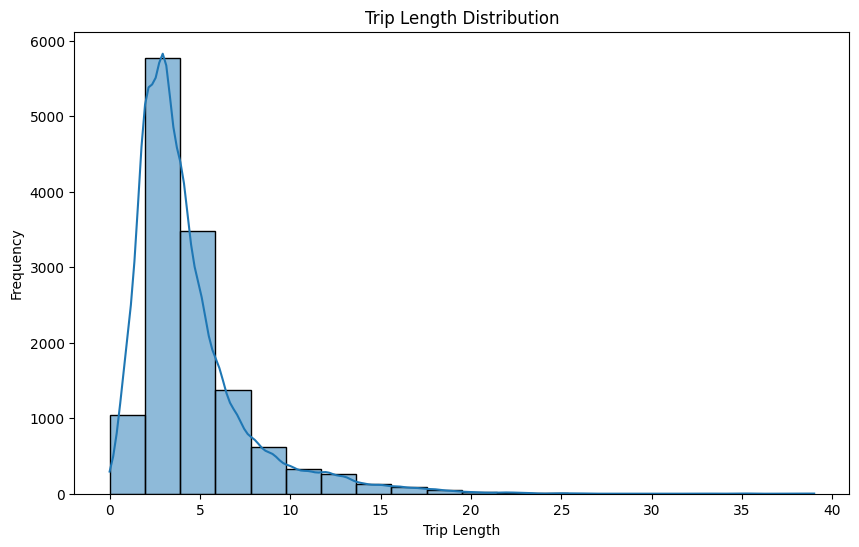

In [ ]:
# Trip Length Histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_flights['trip_length'], bins=20, kde=True)
plt.title('Trip Length Distribution')
plt.xlabel('Trip Length')
plt.ylabel('Frequency')
plt.show()

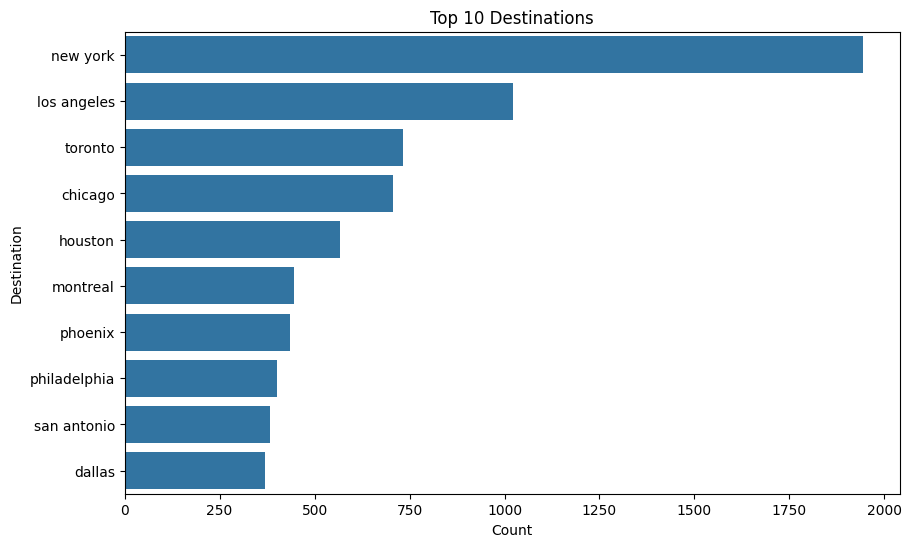

In [ ]:
# Top 10 Desinations
plt.figure(figsize=(10, 6))
sns.countplot(data=df_flights, y='destination', order=df_flights['destination'].value_counts().head(10).index)
plt.title('Top 10 Destinations')
plt.xlabel('Count')
plt.ylabel('Destination')
plt.show()

Text(0.5, 1.0, 'Departure Time Heatmap by Hour')

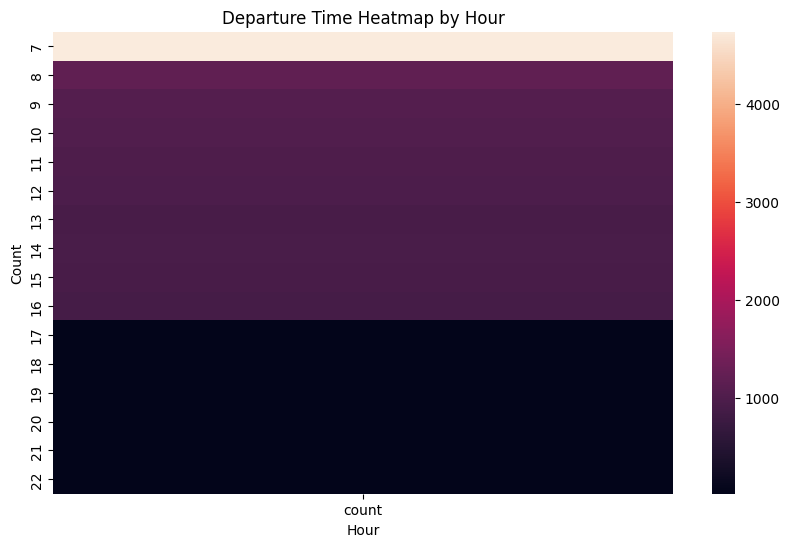

In [ ]:
# Depature heatmap by hour
plt.figure(figsize=(10, 6))
sns.heatmap(df_flights['departure_time'].dt.hour.value_counts().sort_index().to_frame())
plt.xlabel('Hour')
plt.ylabel('Count')
plt.title('Departure Time Heatmap by Hour')

Text(0.5, 1.0, 'Departure Time Heatmap by Day of Week and Hour')

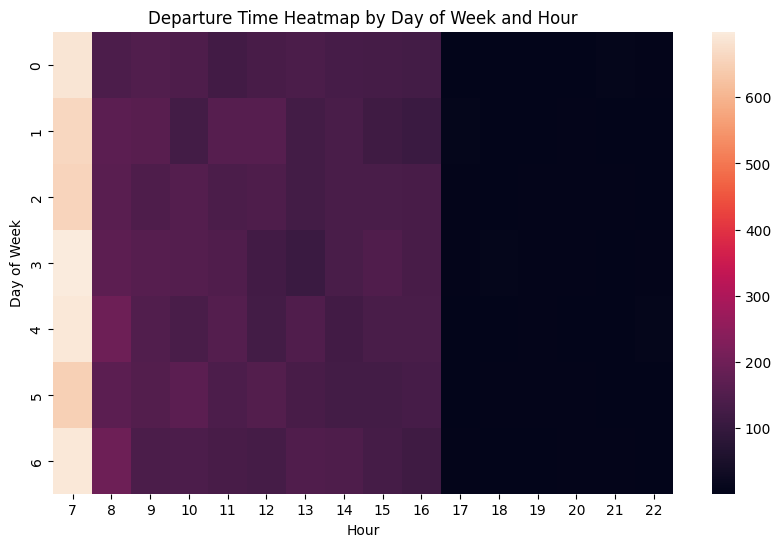

In [ ]:
# Depature heatmap by day of week and hour
plt.figure(figsize=(10, 6))
sns.heatmap(df_flights.groupby([df_flights['departure_time'].dt.dayofweek, df_flights['departure_time'].dt.hour]).size().unstack(), color='blue')
plt.xlabel('Hour')
plt.ylabel('Day of Week')
plt.title('Departure Time Heatmap by Day of Week and Hour')

Departure time is mostly at 7am each day of the week.

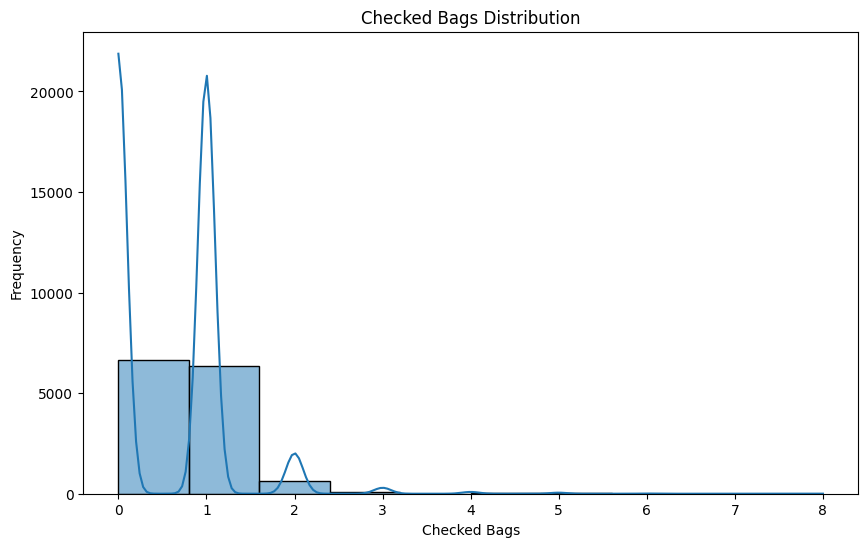

In [ ]:
# Checked Bags Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_flights['checked_bags'], bins=10, kde=True)
plt.title('Checked Bags Distribution')
plt.xlabel('Checked Bags')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Investigate Checked Bags over 5
df_flights[(df_flights['checked_bags'] > 5)]

,trip_id,origin_airport,destination,destination_airport,seats,return_flight_booked,departure_time,return_time,checked_bags,trip_airline,destination_airport_lat,destination_airport_lon,base_fare_usd,trip_length_flight
2484,549800-daea60f97d3e49f6a875a013eb692b98,TYS,los angeles,LAX,2,True,2023-03-08 16:00:00,2023-03-11 16:00:00,6,American Airlines,33.942,-118.408,1117.44,4320.0
2857,529602-ccc54c8a318a4b8a8328a8e20da26544,CLT,amsterdam,AMS,7,True,2024-04-11 10:00:00,2024-04-30 10:00:00,6,Pegasus Airlines,52.309,4.764,8431.34,27360.0
4276,635300-ac715e2db7ea4e53a40d38e0b711c71a,ORD,milwaukee,MKE,2,True,2023-03-13 10:00:00,2023-03-14 10:00:00,6,AirTran Airways,42.947,-87.896,41.58,1440.0
5368,516283-232ec8d8fe874ea49d2b7c771d46c248,PHX,tokyo,NRT,8,True,2023-10-10 18:00:00,2023-10-26 18:00:00,8,All Nippon Airways,35.765,140.386,12935.06,23040.0


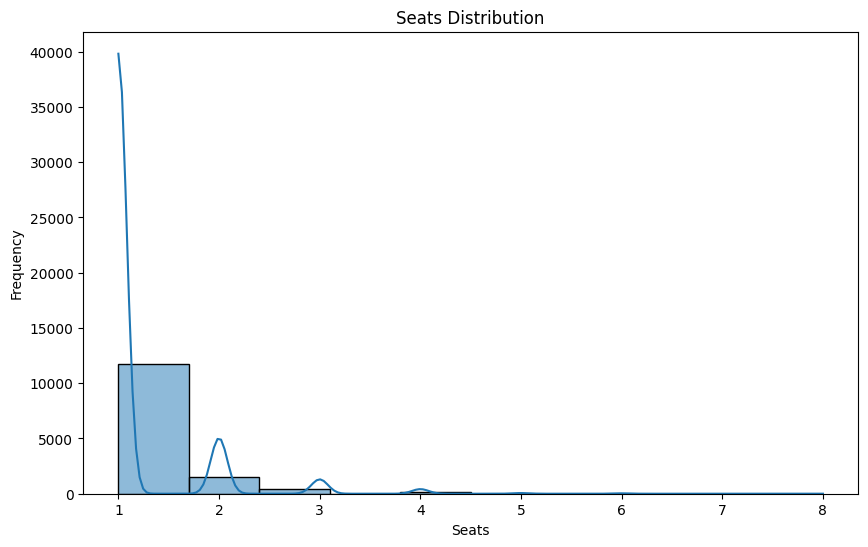

In [ ]:
# Seats Histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_flights['seats'], bins=10, kde=True)
plt.title('Seats Distribution')
plt.xlabel('Seats')
plt.ylabel('Frequency')
plt.show()

###Hotels

In [ ]:
df_hotels.head()

,trip_id,hotel_name,nights,rooms,check_in_time,check_out_time,hotel_per_room_usd
0,535625-70a106f66b294e6b88ef5ba7e83a04a9,Hyatt - philadelphia,3,1,2023-02-22 14:40:11.865,2023-02-26 11:00:00,38
1,548587-1ac3cc409801445d97978c575dd547a1,Conrad - new york,2,1,2023-02-25 17:03:32.94,2023-02-28 11:00:00,426
2,555770-a75973f7da3e4e1c8345b378058696bb,Accor - milwaukee,9,1,2023-02-26 10:43:32.25,2023-03-07 11:00:00,125
3,563740-18fbb7fafd6747d88a2f147d4a8713e2,Crowne Plaza - quebec,0,1,2023-02-24 20:23:43.17,2023-02-25 11:00:00,469
4,541505-e2354dad1daf4550a359a3456641c27c,Hyatt - phoenix,2,1,2023-02-23 14:41:54.915,2023-02-26 11:00:00,73


In [ ]:
df_hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14374 entries, 0 to 14373
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   trip_id             14374 non-null  object         
 1   hotel_name          14374 non-null  object         
 2   nights              14374 non-null  int64          
 3   rooms               14374 non-null  int64          
 4   check_in_time       14374 non-null  object         
 5   check_out_time      14374 non-null  object         
 6   hotel_per_room_usd  14374 non-null  int64          
 7   trip_length_hotel   14374 non-null  timedelta64[ns]
dtypes: int64(3), object(4), timedelta64[ns](1)
memory usage: 898.5+ KB


In [ ]:
df_hotels.duplicated().sum()

np.int64(0)

In [ ]:
# Check nights column
df_hotels['nights'].unique()

array([ 3,  2,  9,  0,  4,  1,  6,  7, 18,  5,  8, 17, 10, 32, -1, 11, 12,
       13, 16, 14, 22, 19, 15, 21, 25, 20, 29, 27, 23, 26, 30, 34, 28, 37,
       35, 31, -2, 40, 24, 33, 43, 47, 36, 42])

Seeing a -1 in the Nights values

In [ ]:
df_hotels[df_hotels['nights'] == -1]

,trip_id,hotel_name,nights,rooms,check_in_time,check_out_time,hotel_per_room_usd
92,372970-10c42843088b49a6bbb6868fbec5abb0,Rosewood - portland,-1,1,2023-03-12 13:34:49.935,2023-03-12 11:00:00,132
271,505771-5e21117bdbf1419eb632c0918be907a3,Hilton - boston,-1,2,2023-04-20 09:30:39.555,2023-04-19 11:00:00,289
289,524211-60b3eb9ff20b48fd9011064718a0d007,NH Hotel - ottawa,-1,1,2023-04-29 14:40:43.050,2023-04-29 11:00:00,245
365,549274-e9762318b4434de09638968f7fe5f2e8,Four Seasons - louisville,-1,1,2023-05-22 09:30:57.375,2023-05-21 11:00:00,81
486,665593-258e19907f8f40f08a502f8754990d5c,Choice Hotels - los angeles,-1,2,2023-07-07 14:11:49.380,2023-07-07 11:00:00,122
...,...,...,...,...,...,...,...
13981,665329-5982cd8252ab4d7d95726beadd67f89e,Fairmont - columbus,-1,2,2023-07-04 14:57:38.250,2023-07-04 11:00:00,91
14094,509282-a2bf5b84091b47a8ab3f12c95f8dd863,Extended Stay - new york,-1,1,2023-01-10 15:51:29.790,2023-01-10 11:00:00,708
14111,516616-de3eb33dbe4e4e0bafbcbc0017c2cd46,Banyan Tree - fresno,-1,1,2023-01-16 20:56:32.325,2023-01-16 11:00:00,78
14115,517732-9f5d6a62cd4647bc93f5d4aa8402d9d5,Crowne Plaza - new york,-1,1,2023-01-19 13:52:45.840,2023-01-19 11:00:00,158


After looking at the data, I'm seeing that because the check-out time is always set to 11:00:00, if the check-in occured after that time, we are getting incorrect calculation of the number of nights.

In [ ]:
# Convert to datetime
df_hotels['check_in_time'] = pd.to_datetime(df_hotels['check_in_time'], format='mixed')
df_hotels['check_out_time'] = pd.to_datetime(df_hotels['check_out_time'], format='mixed')

# Recalculate nights - using the .days property of timedelta objects directly.
df_hotels['nights'] = (df_hotels['check_out_time'] - df_hotels['check_in_time']).dt.days

df_hotels.head()

,trip_id,hotel_name,nights,rooms,check_in_time,check_out_time,hotel_per_room_usd
0,535625-70a106f66b294e6b88ef5ba7e83a04a9,Hyatt - philadelphia,3,1,2023-02-22 14:40:11.865,2023-02-26 11:00:00,38
1,548587-1ac3cc409801445d97978c575dd547a1,Conrad - new york,2,1,2023-02-25 17:03:32.940,2023-02-28 11:00:00,426
2,555770-a75973f7da3e4e1c8345b378058696bb,Accor - milwaukee,9,1,2023-02-26 10:43:32.250,2023-03-07 11:00:00,125
3,563740-18fbb7fafd6747d88a2f147d4a8713e2,Crowne Plaza - quebec,0,1,2023-02-24 20:23:43.170,2023-02-25 11:00:00,469
4,541505-e2354dad1daf4550a359a3456641c27c,Hyatt - phoenix,2,1,2023-02-23 14:41:54.915,2023-02-26 11:00:00,73


In [ ]:
#check -1
df_hotels[df_hotels['nights'] == -1]

,trip_id,hotel_name,nights,rooms,check_in_time,check_out_time,hotel_per_room_usd
271,505771-5e21117bdbf1419eb632c0918be907a3,Hilton - boston,-1,2,2023-04-20,2023-04-19,289
365,549274-e9762318b4434de09638968f7fe5f2e8,Four Seasons - louisville,-1,1,2023-05-22,2023-05-21,81
563,441200-adc8d2b1b65a4ccf8c28df3be616c6a2,Fairmont - dallas,-1,1,2022-12-08,2022-12-07,195
674,518998-bdc08a2047d545d2b2b024aac212a5f6,Extended Stay - new york,-1,1,2023-01-30,2023-01-29,244
1159,602598-22e0198df949454b92c7ee3f00d103f5,Conrad - charlotte,-1,3,2023-05-02,2023-05-01,206
1704,543778-cdc9bc67fc074436ba74c4bdacaf59ad,Aman Resorts - fort worth,-1,1,2023-02-19,2023-02-18,92
2105,566875-ec782975633b4a48a5486870fd121934,NH Hotel - new york,-1,1,2023-05-22,2023-05-21,52
2246,506250-134d680a8ca64d99aba801607c3ed32d,Radisson - san antonio,-1,1,2023-07-08,2023-07-07,161
2553,530118-4b5c287a469d46a4ae31b285938524ba,Extended Stay - montreal,-1,1,2023-02-13,2023-02-12,437
2563,562869-68a4238d4adc4246b669bf66c43845ca,Crowne Plaza - quebec,-1,2,2023-02-15,2023-02-14,256


Becasue I am still seeing an issue with negative values, I am going to change the value to 1. The user would not have checked out before checking in, so I am going to assume these values are an error.

In [ ]:
df_hotels.loc[df_hotels['nights'] == -1, 'nights'] = 1
df_hotels[df_hotels['nights'] == -1]

,trip_id,hotel_name,nights,rooms,check_in_time,check_out_time,hotel_per_room_usd


In [ ]:
#count nan
df_hotels.isna().sum()

,0
trip_id,0
hotel_name,0
nights,0
rooms,0
check_in_time,0
check_out_time,0
hotel_per_room_usd,0


In [ ]:
# Seasonality
df_hotels['travel_month'] = df_hotels['check_in_time'].dt.month
df_hotels.head()


,trip_id,hotel_name,nights,rooms,check_in_time,check_out_time,hotel_per_room_usd,travel_month
0,535625-70a106f66b294e6b88ef5ba7e83a04a9,Hyatt - philadelphia,3,1,2023-02-22 14:40:11.865,2023-02-26 11:00:00,38,2
1,548587-1ac3cc409801445d97978c575dd547a1,Conrad - new york,2,1,2023-02-25 17:03:32.940,2023-02-28 11:00:00,426,2
2,555770-a75973f7da3e4e1c8345b378058696bb,Accor - milwaukee,9,1,2023-02-26 10:43:32.250,2023-03-07 11:00:00,125,2
3,563740-18fbb7fafd6747d88a2f147d4a8713e2,Crowne Plaza - quebec,0,1,2023-02-24 20:23:43.170,2023-02-25 11:00:00,469,2
4,541505-e2354dad1daf4550a359a3456641c27c,Hyatt - phoenix,2,1,2023-02-23 14:41:54.915,2023-02-26 11:00:00,73,2


<Axes: xlabel='travel_month', ylabel='count'>

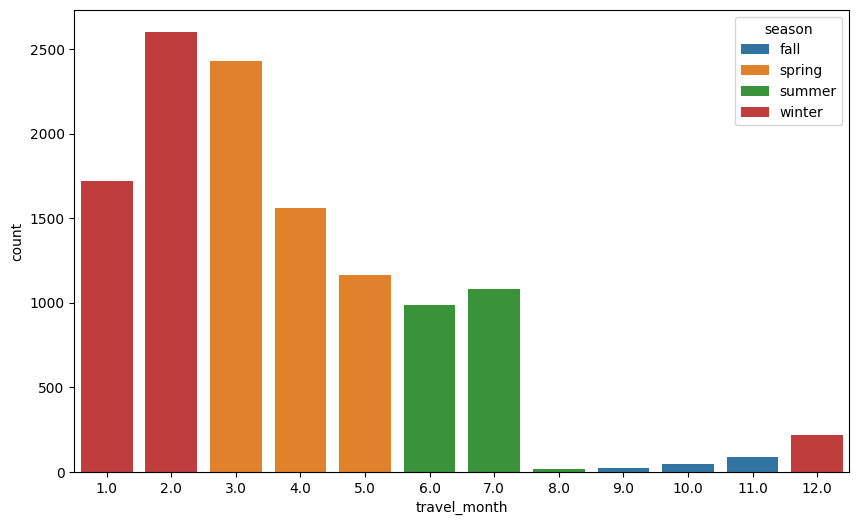

In [ ]:
# Seasonality
df_hotels['travel_month'] = df_hotels['check_in_time'].dt.month

# Create a new column 'season' based on 'travel_month'
df_hotels['season'] = pd.cut(df_hotels['travel_month'],
                              bins=[0, 2, 5, 8, 11, 12],
                              labels=['winter', 'spring', 'summer', 'fall', 'winter'],
                              include_lowest=True,
                              ordered=False) # added to remove warning

# Seasonality graph
plt.figure(figsize=(10, 6))
sns.countplot(data=df_hotels, x='travel_month', hue='season')

###Sessions

In [ ]:
df_sessions.head()

,session_id,user_id,trip_id,session_start,session_end,flight_discount,hotel_discount,flight_discount_amount,hotel_discount_amount,flight_booked,hotel_booked,page_clicks,cancellation
0,465731-d72957431d5b4c31812d06e052715522,465731,465731-71a801a4c6214bf2b4ecb0bc56dc3fd7,2023-07-17 16:28:00,2023-07-17 16:38:45,False,False,NaN,NaN,True,True,87,False
1,504371-dfed9874335548c49eb44998e9cda4cb,504371,504371-41c3f1d6739d4b7981a0d68ce8d0e11b,2023-07-17 17:35:00,2023-07-17 17:37:59,False,False,NaN,NaN,True,True,24,False
2,528061-e8e9bbaee4b149849d960b137df36bb7,528061,528061-5550ed4c63444843bcb1f2c47eab57d8,2023-07-17 12:43:00,2023-07-17 12:45:35,False,False,NaN,NaN,True,True,21,False
3,538279-cfb8fe96f39b493db244a5f1ca58041a,538279,538279-1b5ca1ab69214ccc9cf5dd5e85470dab,2023-07-17 17:09:00,2023-07-17 17:11:17,False,False,NaN,NaN,True,True,18,False
4,549313-2b7de2c9ae2b407d8769fddf36538f02,549313,549313-185a0d917c0f414c88a1e8d96e3613eb,2023-07-17 21:47:00,2023-07-17 21:49:38,False,False,NaN,NaN,True,True,21,False


In [ ]:
df_sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16778 entries, 0 to 16777
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   session_id              16778 non-null  object 
 1   user_id                 16778 non-null  int64  
 2   trip_id                 16778 non-null  object 
 3   session_start           16778 non-null  object 
 4   session_end             16778 non-null  object 
 5   flight_discount         16778 non-null  bool   
 6   hotel_discount          16778 non-null  bool   
 7   flight_discount_amount  2394 non-null   float64
 8   hotel_discount_amount   2246 non-null   float64
 9   flight_booked           16778 non-null  bool   
 10  hotel_booked            16778 non-null  bool   
 11  page_clicks             16778 non-null  int64  
 12  cancellation            16778 non-null  bool   
dtypes: bool(5), float64(2), int64(2), object(4)
memory usage: 1.1+ MB


In [ ]:
df_sessions.duplicated().sum()

np.int64(0)

In [ ]:
# Avg page clicks
print(df_sessions['page_clicks'].mean())

29.59655501251639


In [ ]:
# Median page clicks
print(df_sessions['page_clicks'].median())

22.0


<Axes: ylabel='page_clicks'>

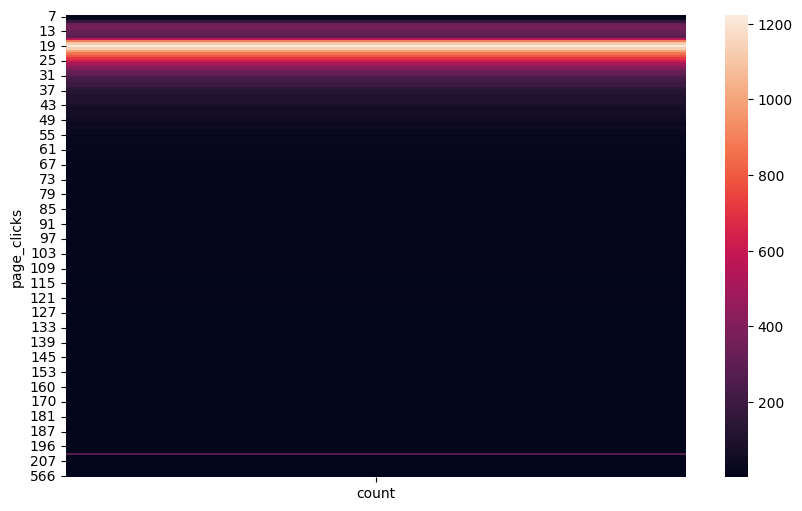

In [ ]:
# Page clicks heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_sessions['page_clicks'].value_counts().sort_index().to_frame())

<Axes: xlabel='page_clicks', ylabel='Count'>

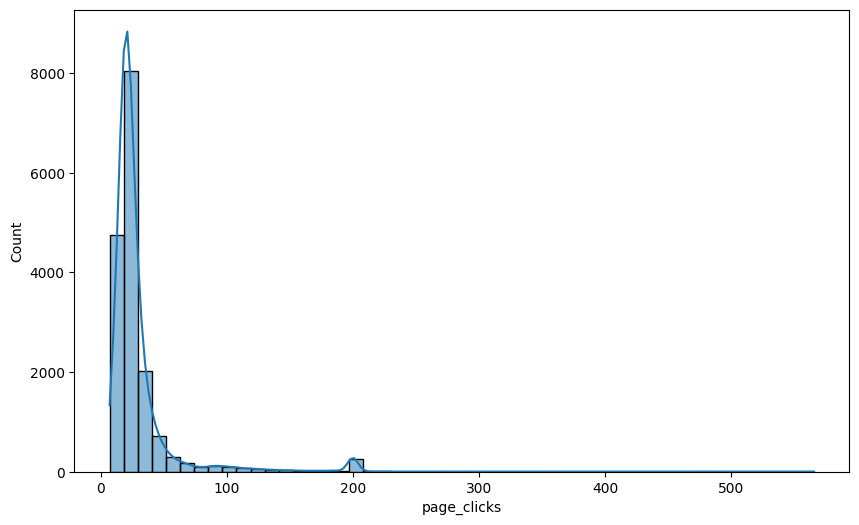

In [ ]:
# Page clicks histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_sessions['page_clicks'], bins=50, kde=True)

Add Session Duration

In [ ]:
# Convert to Datetime
df_sessions['session_start'] = pd.to_datetime(df_sessions['session_start'])
df_sessions['session_end'] = pd.to_datetime(df_sessions['session_end'], format='mixed') # Use format='mixed' to handle inconsistent formats

# Session Duration
df_sessions['session_duration'] = df_sessions['session_end'] - df_sessions['session_start']
df_sessions['session_duration'] = df_sessions['session_duration'].dt.total_seconds() / 60
df_sessions.head()

,session_id,user_id,trip_id,session_start,session_end,flight_discount,hotel_discount,flight_discount_amount,hotel_discount_amount,flight_booked,hotel_booked,page_clicks,cancellation,session_duration
0,465731-d72957431d5b4c31812d06e052715522,465731,465731-71a801a4c6214bf2b4ecb0bc56dc3fd7,2023-07-17 16:28:00,2023-07-17 16:38:45,False,False,NaN,NaN,True,True,87,False,10.750000
1,504371-dfed9874335548c49eb44998e9cda4cb,504371,504371-41c3f1d6739d4b7981a0d68ce8d0e11b,2023-07-17 17:35:00,2023-07-17 17:37:59,False,False,NaN,NaN,True,True,24,False,2.983333
2,528061-e8e9bbaee4b149849d960b137df36bb7,528061,528061-5550ed4c63444843bcb1f2c47eab57d8,2023-07-17 12:43:00,2023-07-17 12:45:35,False,False,NaN,NaN,True,True,21,False,2.583333
3,538279-cfb8fe96f39b493db244a5f1ca58041a,538279,538279-1b5ca1ab69214ccc9cf5dd5e85470dab,2023-07-17 17:09:00,2023-07-17 17:11:17,False,False,NaN,NaN,True,True,18,False,2.283333
4,549313-2b7de2c9ae2b407d8769fddf36538f02,549313,549313-185a0d917c0f414c88a1e8d96e3613eb,2023-07-17 21:47:00,2023-07-17 21:49:38,False,False,NaN,NaN,True,True,21,False,2.633333


<Axes: xlabel='session_duration', ylabel='Count'>

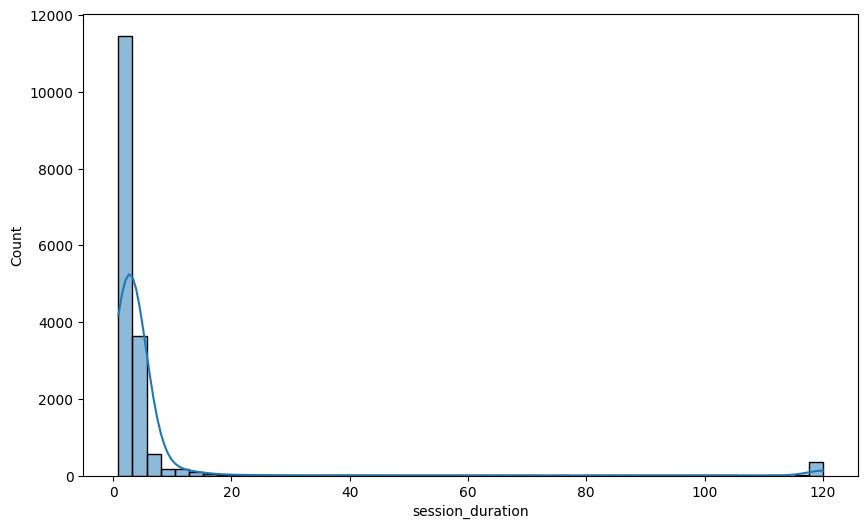

In [ ]:
# Session duration histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_sessions['session_duration'], bins=50, kde=True)

In [ ]:
# Cancellation count
df_sessions['cancellation'].value_counts()

,count
cancellation,
False,16164
True,614


In [ ]:
# Cancellation percent
df_sessions['cancellation'].value_counts(normalize=True)

,proportion
cancellation,
False,0.963404
True,0.036596


In [ ]:
# Hotel booked x Flight booked
pd.crosstab(df_sessions['hotel_booked'], df_sessions['flight_booked'])

flight_booked,False,True
hotel_booked,,
False,0,1790
True,2397,12591


In [ ]:
# Avg hotel discount
print(f'Avg Hotel Discount {df_sessions["hotel_discount"].mean()}')
# Avg Flight Discount
print(f'Avg Flight Discount {df_sessions["flight_discount"].mean()}')

Avg Hotel Discount 0.17046131839313386
Avg Flight Discount 0.17928239361068066


Getting total price of flights and hotels

In [ ]:
df_hotels['total_price'] = df_hotels['rooms'] * df_hotels['hotel_per_room_usd'] * df_hotels['nights']
df_flights['total_price'] = df_flights['seats'] * df_flights['base_fare_usd']

df_flights.head()

,trip_id,origin_airport,destination,destination_airport,seats,return_flight_booked,departure_time,return_time,checked_bags,trip_airline,destination_airport_lat,destination_airport_lon,base_fare_usd,trip_length,total_price
0,572396-98da506db3d94c80b194abc038a7d51a,MSN,calgary,YYC,1,True,2023-03-26 15:00:00,2023-03-30 15:00:00,0,Allegiant Air,51.114,-114.020,311.80,4.0,311.80
1,579829-5fe304c39c3e4b1584721fff699508fa,YYC,baltimore,BWI,1,True,2023-03-19 14:00:00,2023-03-23 14:00:00,1,AirTran Airways,39.175,-76.668,533.31,4.0,533.31
2,593350-e920794dbd694a8ab670580534fd6ddb,MHR,el paso,ELP,3,True,2023-03-20 14:00:00,2023-03-25 14:00:00,0,Allegiant Air,31.849,-106.380,807.74,5.0,2423.22
3,252835-db62add9d6364162adc85cc234a12552,ORD,phoenix,PHX,1,True,2023-03-21 10:00:00,2023-03-27 10:00:00,1,American Airlines,33.535,-112.383,444.21,6.0,444.21
4,281952-e45eebaa33114910a96edc7e5f3b0a4f,LOU,new york,LGA,1,True,2023-03-20 07:00:00,2023-03-22 07:00:00,1,Delta Air Lines,40.640,-73.779,199.85,2.0,199.85


#Create Master User Dataset
Using these dfs for new features and insights

In [ ]:
# Join sessions with hotels and flights on trip_id
df_trip = df_sessions.merge(df_hotels, on='trip_id', how='left') \
                     .merge(df_flights, on='trip_id', how='left')

# Join trip_df with users on user_id
df_master = df_trip.merge(df_users, on='user_id', how='left')
df_master.head()

,session_id,user_id,trip_id,session_start,session_end,flight_discount,hotel_discount,flight_discount_amount,hotel_discount_amount,flight_booked,...,has_children,home_country,home_city,home_airport,home_airport_lat,home_airport_lon,sign_up_date,age,age_group,months_on_site
0,465731-d72957431d5b4c31812d06e052715522,465731,465731-71a801a4c6214bf2b4ecb0bc56dc3fd7,2023-07-17 16:28:00,2023-07-17 16:38:45,False,False,NaN,NaN,True,...,False,usa,phoenix,LUF,33.535,-112.383,2022-12-13,57,56-65,28
1,504371-dfed9874335548c49eb44998e9cda4cb,504371,504371-41c3f1d6739d4b7981a0d68ce8d0e11b,2023-07-17 17:35:00,2023-07-17 17:37:59,False,False,NaN,NaN,True,...,True,usa,new york,LGA,40.777,-73.872,2023-01-01,52,46-55,27
2,528061-e8e9bbaee4b149849d960b137df36bb7,528061,528061-5550ed4c63444843bcb1f2c47eab57d8,2023-07-17 12:43:00,2023-07-17 12:45:35,False,False,NaN,NaN,True,...,False,usa,new york,LGA,40.777,-73.872,2023-01-13,42,36-45,27
3,538279-cfb8fe96f39b493db244a5f1ca58041a,538279,538279-1b5ca1ab69214ccc9cf5dd5e85470dab,2023-07-17 17:09:00,2023-07-17 17:11:17,False,False,NaN,NaN,True,...,False,usa,dallas,DAL,32.847,-96.852,2023-01-18,50,46-55,27
4,549313-2b7de2c9ae2b407d8769fddf36538f02,549313,549313-185a0d917c0f414c88a1e8d96e3613eb,2023-07-17 21:47:00,2023-07-17 21:49:38,False,False,NaN,NaN,True,...,True,usa,corpus christi,CRP,27.770,-97.501,2023-01-24,45,36-45,26


#Feature Engineering

Total number of trips by user

In [ ]:
# Total number of trips by user
num_trips = df_trip.groupby('user_id')['trip_id'].nunique().reset_index()
num_trips.rename(columns={'trip_id': 'num_trips'}, inplace=True)


Avg trip length by user

In [ ]:
# Avg trip length by user
avg_trip_length = df_trip.groupby('user_id')['trip_length'].mean().reset_index()
avg_trip_length.rename(columns={'trip_length': 'avg_trip_length'}, inplace=True)

Avg trip price by user

In [ ]:
# Avg trip price by user
df_trip['total_price'] = df_trip['total_price_x'] + df_trip['total_price_y']

avg_trip_price = df_trip.groupby('user_id')['total_price'].mean().reset_index()
avg_trip_price.rename(columns={'total_price': 'avg_trip_price'}, inplace=True)

Total user value

In [ ]:
# Total user value
total_user_value = df_trip.groupby('user_id')['total_price'].sum().reset_index()
total_user_value.rename(columns={'total_price': 'total_user_value'}, inplace=True)

Avg discount by user

In [ ]:
# Ensure discount is numeric
df_trip['hotel_discount'] = pd.to_numeric(df_trip['hotel_discount'], errors='coerce')
df_trip['flight_discount'] = pd.to_numeric(df_trip['flight_discount'], errors='coerce')

# Avg discount by user
avg_discount = df_trip.groupby('user_id')['hotel_discount'].mean().reset_index()
avg_discount.rename(columns={'hotel_discount': 'avg_hotel_discount'}, inplace=True)


Avg number of checked bags

Avg number of seats per flight

Avg number of rooms


In [ ]:
# Avg number of checked bags
avg_checked_bags = df_trip.groupby('user_id')['checked_bags'].mean().reset_index()
avg_checked_bags.rename(columns={'checked_bags': 'avg_checked_bags'}, inplace=True)

# Avg number of seats per flight
avg_seats = df_trip.groupby('user_id')['seats'].mean().reset_index()
avg_seats.rename(columns={'seats': 'avg_seats'}, inplace=True)

# Avg number of rooms
avg_rooms = df_trip.groupby('user_id')['rooms'].mean().reset_index()
avg_rooms.rename(columns={'rooms': 'avg_rooms'}, inplace=True)

Has user cancelled trips?

In [ ]:
# Has user cancelled trips
has_cancelled = df_trip.groupby('user_id')['cancellation'].any().reset_index()
has_cancelled.rename(columns={'cancellation': 'has_cancelled'}, inplace=True)
# Remove cancelled users
has_cancelled = has_cancelled[has_cancelled['has_cancelled'] == True]
df_master = df_master[~df_master['user_id'].isin(has_cancelled['user_id'])]

Avg trip length in days

In [ ]:
# Convert dates to datetime
df_master['session_start'] = pd.to_datetime(df_master['session_start'])
df_master['session_end'] = pd.to_datetime(df_master['session_end'])

# Trip length in days
df_master['trip_length'] = (df_master['session_end'] - df_master['session_start']).dt.days

# Group by user
user_trip_length = df_master.groupby('user_id')['trip_length'].mean().reset_index()
user_trip_length.rename(columns={'trip_length': 'avg_trip_length'}, inplace=True)


Encode Categorical Variables

In [ ]:
# Change Gender to 0,1,2
df_users['gender'] = df_users['gender'].map({'M': 0, 'F': 1, 'O': 2})
df_users.head()

,user_id,birthdate,gender,married,has_children,home_country,home_city,home_airport,home_airport_lat,home_airport_lon,sign_up_date,age,age_group,months_on_site
0,531931,1984-05-26,1,False,False,usa,san jose,SJC,37.362,-121.929,2023-01-15,40,36-45,27
1,611065,1981-08-20,1,False,False,usa,los angeles,LAX,33.942,-118.408,2023-02-22,43,36-45,25
2,586762,1987-09-26,1,False,False,canada,montreal,YUL,45.468,-73.741,2023-02-11,37,36-45,26
3,229330,1976-11-08,1,True,False,usa,colorado springs,COS,38.806,-104.700,2022-06-27,48,46-55,33
4,536035,1995-11-09,0,False,False,usa,new york,LGA,40.777,-73.872,2023-01-17,29,26-35,27


In [ ]:
# Convert to numerical 0,1
df_users['married'] = df_users['married'].map({True: 1, False: 0})
df_users['has_children'] = df_users['has_children'].map({True: 1, False: 0})
df_users['home_country'] = df_users['home_country'].map({'usa': 1, 'canada': 0})

df_users.head()


,user_id,birthdate,gender,married,has_children,home_country,home_city,home_airport,home_airport_lat,home_airport_lon,sign_up_date,age,age_group,months_on_site
0,531931,1984-05-26,1,0,0,1,san jose,SJC,37.362,-121.929,2023-01-15,40,36-45,27
1,611065,1981-08-20,1,0,0,1,los angeles,LAX,33.942,-118.408,2023-02-22,43,36-45,25
2,586762,1987-09-26,1,0,0,0,montreal,YUL,45.468,-73.741,2023-02-11,37,36-45,26
3,229330,1976-11-08,1,1,0,1,colorado springs,COS,38.806,-104.700,2022-06-27,48,46-55,33
4,536035,1995-11-09,0,0,0,1,new york,LGA,40.777,-73.872,2023-01-17,29,26-35,27


In [ ]:
# Encode Age Groups
#df_users['age_group'] = df_users['age_group'].map({'0-18': 0, '19-25': 1, '26-35': 2, '36-45': 3, '46-55': 4, '56-65': 5, '66+': 6})

#Remove Age Groups
df_users = df_users.drop(['age_group'], axis=1)

In [ ]:
# Avg Clicks per booking by user
df_sessions['page_clicks'] = df_sessions['page_clicks'].astype(float)

avg_clicks = df_sessions.groupby('user_id')['page_clicks'].mean().reset_index()
avg_clicks.rename(columns={'page_clicks': 'avg_clicks'}, inplace=True)

# Avg Session length by user_id
df_sessions['session_duration'] = df_sessions['session_end'] - df_sessions['session_start']
df_sessions['session_duration'] = df_sessions['session_duration'].dt.total_seconds() / 60

avg_session_length = df_sessions.groupby('user_id')['session_duration'].mean().reset_index()
avg_session_length.rename(columns={'session_duration': 'avg_session_length'}, inplace=True)

In [ ]:
# Drop unused cat columns
#df_users = df_users.drop(["birthdate","sign_up_date"])
#df_users = df_users.drop(["home_city","home_airport"])
#df_users = df_users.drop(["home_airport_lat","home_airport_lon"])

df_users.head()

,user_id,birthdate,gender,married,has_children,home_country,home_city,home_airport,home_airport_lat,home_airport_lon,sign_up_date,age,months_on_site
0,531931,1984-05-26,1,0,0,1,san jose,SJC,37.362,-121.929,2023-01-15,40,27
1,611065,1981-08-20,1,0,0,1,los angeles,LAX,33.942,-118.408,2023-02-22,43,25
2,586762,1987-09-26,1,0,0,0,montreal,YUL,45.468,-73.741,2023-02-11,37,26
3,229330,1976-11-08,1,1,0,1,colorado springs,COS,38.806,-104.700,2022-06-27,48,33
4,536035,1995-11-09,0,0,0,1,new york,LGA,40.777,-73.872,2023-01-17,29,27


Create final features df

In [ ]:
# Start with users
features_df = df_users[['user_id']].copy()

# Merge all features
features_df = features_df.merge(avg_discount, on='user_id', how='left') \
                         .merge(num_trips, on='user_id', how='left') \
                         .merge(avg_trip_price, on='user_id', how='left') \
                         .merge(avg_trip_length, on='user_id', how='left') \
                         .merge(total_user_value, on='user_id', how='left') \
                         .merge(avg_checked_bags, on='user_id', how='left') \
                         .merge(avg_seats, on='user_id', how='left') \
                         .merge(avg_rooms, on='user_id', how='left') \
                         .merge(user_trip_length, on='user_id', how='left') \
                         .merge(avg_session_length, on='user_id', how='left') \
                         .merge(avg_clicks, on='user_id', how='left') \
                         .merge(df_users, on='user_id', how='left') \


features_df.head()


,user_id,avg_hotel_discount,num_trips,avg_trip_price,avg_trip_length_x,total_user_value,avg_checked_bags,avg_seats,avg_rooms,avg_trip_length_y,...,married,has_children,home_country,home_city,home_airport,home_airport_lat,home_airport_lon,sign_up_date,age,months_on_site
0,531931,0.0,2.0,2169.130000,3.5,4338.26,0.500000,1.500000,1.500000,0.0,...,0,0,1,san jose,SJC,37.362,-121.929,2023-01-15,40,27
1,611065,0.0,4.0,2198.372500,2.5,8793.49,0.750000,1.500000,1.500000,0.0,...,0,0,1,los angeles,LAX,33.942,-118.408,2023-02-22,43,25
2,586762,0.0,3.0,2702.163333,8.0,8106.49,0.333333,1.333333,1.333333,0.0,...,0,0,0,montreal,YUL,45.468,-73.741,2023-02-11,37,26
3,229330,0.0,5.0,1424.498000,3.8,7122.49,0.200000,1.600000,1.600000,0.0,...,1,0,1,colorado springs,COS,38.806,-104.700,2022-06-27,48,33
4,536035,0.0,2.0,1094.700000,2.5,2189.40,0.500000,1.500000,1.500000,0.0,...,0,0,1,new york,LGA,40.777,-73.872,2023-01-17,29,27


#Data Cleaning

###Fix NaN values

In [ ]:
features_df.isna().sum()

,0
user_id,0
avg_hotel_discount,421
num_trips,421
avg_trip_price,991
avg_trip_length_x,825
total_user_value,421
avg_checked_bags,772
avg_seats,772
avg_rooms,545
avg_trip_length_y,1017


Replace nan with 0 as a replacement for values that are the result of never booking

In [ ]:
# Replace nan with 0
features_df.fillna({
    'avg_hotel_discount': 0,
    'num_trips': 0,
    'avg_trip_length': 0,
    'has_booked_hotel': 0,
    'has_booked_flight': 0,
    'total_user_value': 0,
    'avg_checked_bags': 0,
    'avg_flight_seats': 0,
    'avg_hotel_rooms': 0,
    'avg_session_length': 0,
    'avg_clicks': 0,
    'avg_trip_price': 0,
    'avg_trip_length_x': 0,
    'avg_trip_length_y': 0,
    'avg_seats': 0,
    'avg_rooms': 0

}, inplace=True)


In [ ]:
features_df.isna().sum().sum()

np.int64(0)

In [ ]:
features_df.isna().sum()

,0
user_id,0
avg_hotel_discount,0
num_trips,0
avg_trip_price,0
avg_trip_length_x,0
total_user_value,0
avg_checked_bags,0
avg_seats,0
avg_rooms,0
avg_trip_length_y,0


###Check outliers

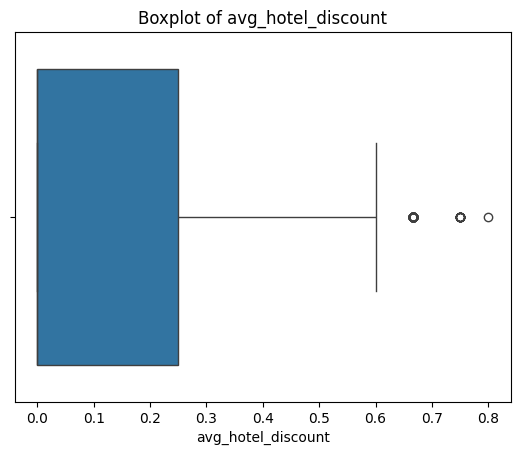

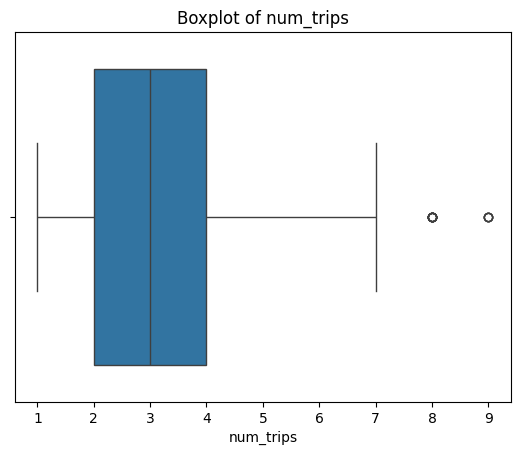

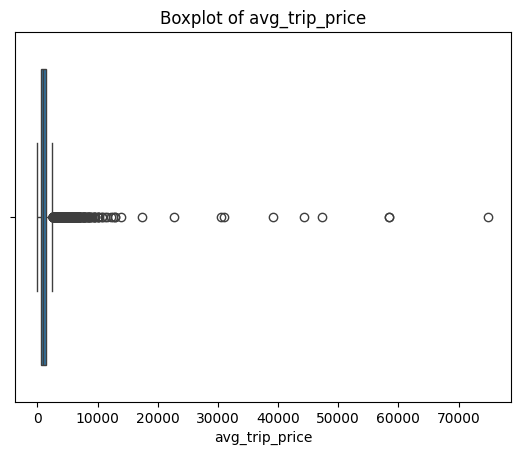

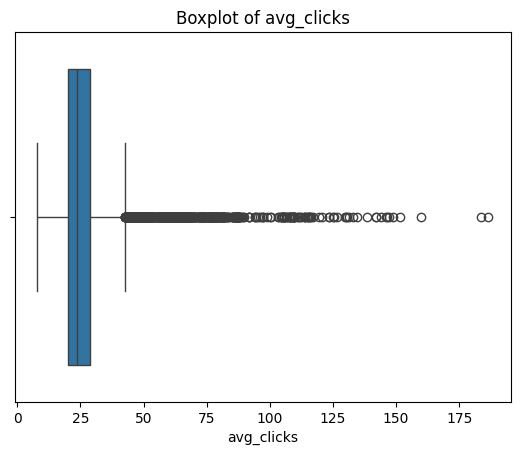

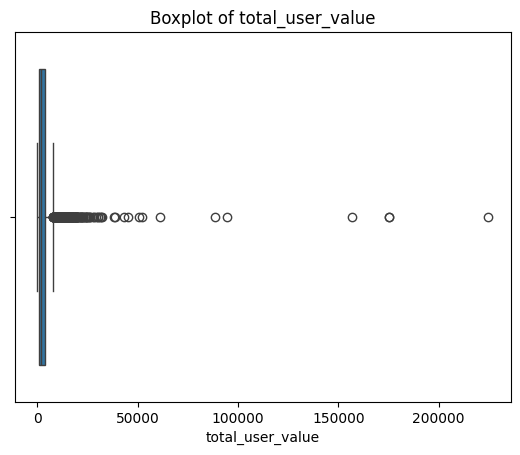

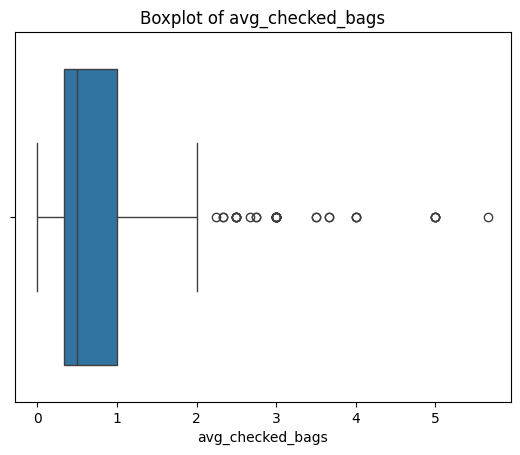

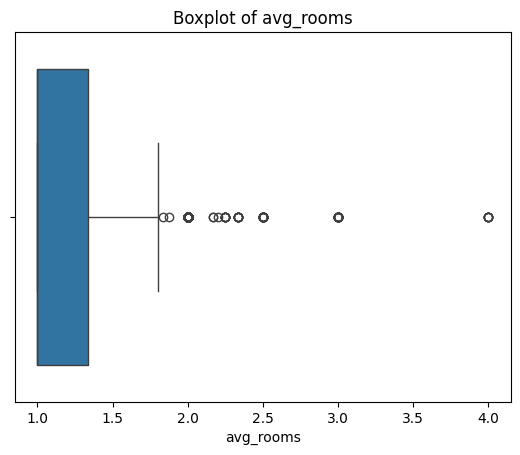

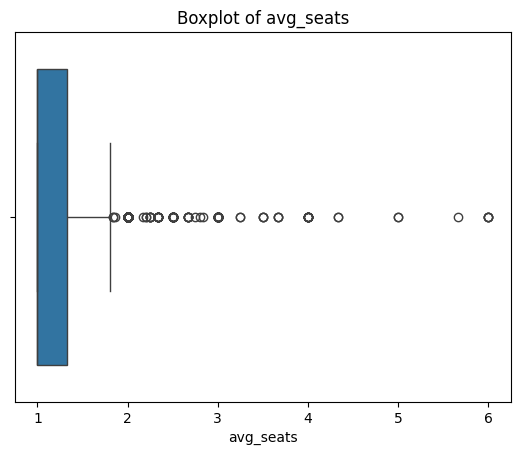

In [ ]:
numeric_cols = ['avg_hotel_discount', 'num_trips', 'avg_trip_price', 'avg_clicks',
                'total_user_value', 'avg_checked_bags', 'avg_rooms', 'avg_seats']

for col in numeric_cols:
    sns.boxplot(x=features_df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

In [ ]:
# Features
numeric_cols = ['total_user_value']

outliers_iqr = pd.Series(False, index=features_df.index)

for col in numeric_cols:
    Q1 = features_df[col].quantile(0.25)
    Q3 = features_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_iqr |= (features_df[col] < lower_bound) | (features_df[col] > upper_bound)

outlier_users_iqr = features_df[outliers_iqr]['user_id'].tolist()
print(f"Number of outlier users: {len(outlier_users_iqr)}")

print(outlier_users_iqr)
features_df[features_df['user_id'].isin(outlier_users_iqr)]

Number of outlier users: 340
[611065, 586762, 477730, 545879, 527346, 494590, 522276, 204997, 564596, 499366, 525056, 216796, 523735, 531253, 347778, 519896, 525234, 669329, 232647, 538279, 521818, 542843, 654259, 531427, 542937, 181157, 635303, 663017, 510841, 532233, 519254, 544685, 542065, 547006, 582038, 528816, 409073, 504133, 576985, 512835, 544254, 515639, 498287, 533291, 564736, 512976, 516806, 541699, 552944, 609262, 649378, 545805, 560627, 519469, 533755, 531467, 598185, 549058, 646937, 659161, 625400, 573379, 551088, 512928, 585585, 531771, 563592, 487453, 552597, 588507, 560978, 672009, 491617, 530463, 454920, 555521, 582768, 485393, 582723, 531654, 543081, 516283, 531557, 526332, 560085, 153982, 559469, 476665, 539566, 508625, 546882, 106907, 511800, 497077, 583446, 560245, 524821, 528061, 125845, 543304, 101486, 566336, 513408, 552623, 249521, 583764, 338086, 569239, 572992, 486751, 727886, 438985, 557963, 595958, 492287, 558277, 389759, 653640, 516057, 525332, 552313, 49

,user_id,avg_hotel_discount,num_trips,avg_trip_price,avg_trip_length_x,total_user_value,avg_checked_bags,avg_seats,avg_rooms,has_cancelled,avg_trip_length_y,avg_session_length,avg_clicks,gender,married,has_children,home_country,age,months_on_site,age_group
1,611065,0.000000,4.0,2198.372500,2.500000,8793.49,0.750000,1.500000,1.500000,False,0.0,3.308333,27.000000,1,0,0,1,43,25,3
2,586762,0.000000,3.0,2702.163333,8.000000,8106.49,0.333333,1.333333,1.333333,False,0.0,2.800000,22.666667,1,0,0,0,37,26,3
6,477730,0.200000,5.0,2047.184000,5.400000,10235.92,0.000000,1.200000,1.200000,False,0.0,4.146667,33.600000,1,0,0,1,46,28,4
18,545879,0.250000,3.0,3159.060000,10.500000,12636.24,0.500000,1.500000,1.000000,True,0.0,17.801191,38.250000,1,0,0,1,27,26,2
32,527346,0.000000,3.0,3971.635000,2.333333,7943.27,0.333333,2.000000,2.500000,False,0.0,2.894444,23.000000,1,1,0,0,47,27,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5741,521152,0.000000,3.0,3068.830000,6.333333,9206.49,0.000000,1.666667,1.666667,False,0.0,2.883333,23.333333,1,1,0,0,46,27,4
5751,552366,0.500000,4.0,6546.270000,4.000000,19638.81,0.333333,2.666667,2.250000,False,0.0,2.325000,18.750000,1,0,0,1,40,26,3
5770,331039,0.666667,2.0,8461.643333,7.000000,25384.93,2.000000,3.000000,1.666667,True,0.0,24.318676,43.333333,1,1,1,0,45,31,3
5773,514980,0.571429,7.0,1619.741429,5.571429,11338.19,0.571429,1.428571,1.428571,False,0.0,2.764286,22.571429,0,0,0,1,40,27,3


When looking more closely at the outliers for total_user_value, we are seeing some very high-spenders. We could possibly use this to classify luxury vs budget users based on number of trips, or whale (high-spending) customers.

#Dimensionality Reduction - PCA
All of the features must be numeric and scaled

###Correlation Matrix

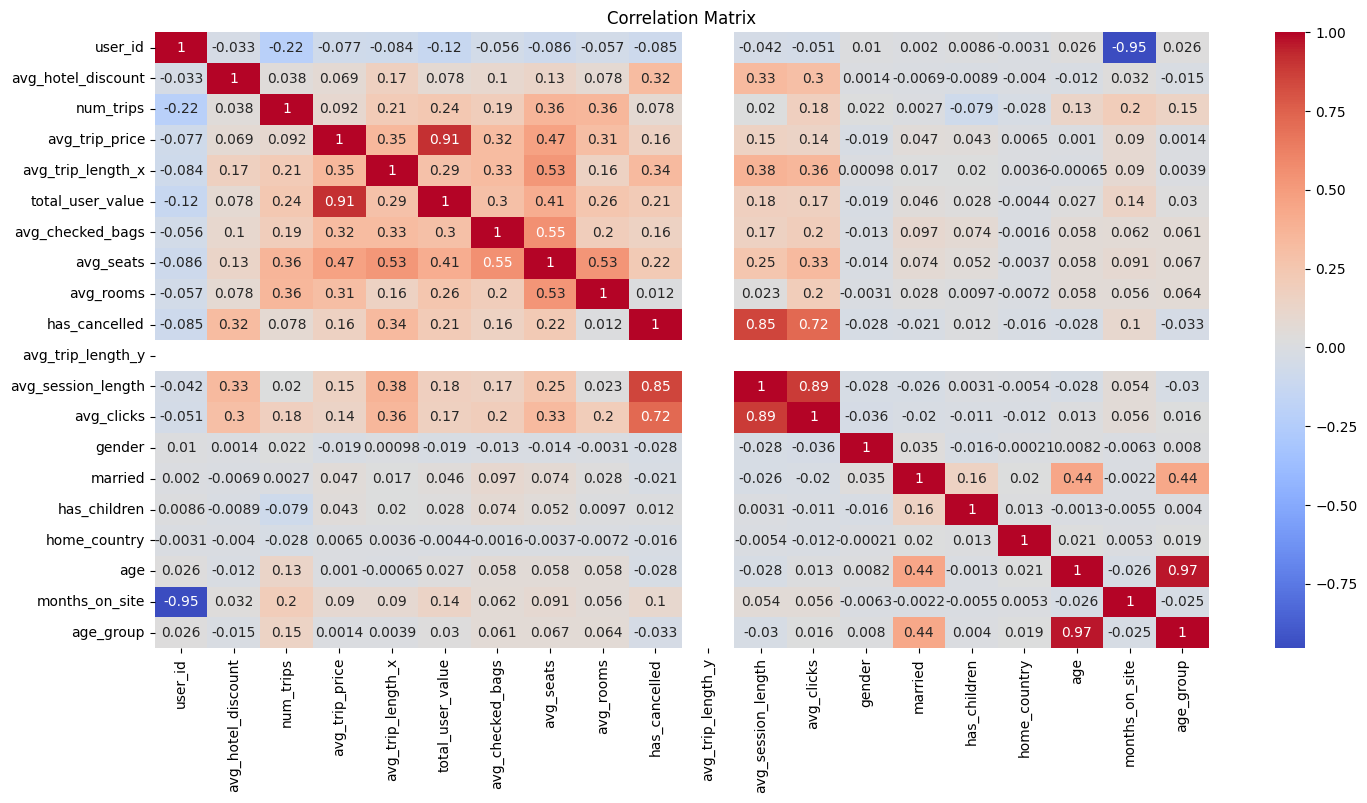

In [ ]:
# Correlation Matrix
plt.figure(figsize=(17, 8))
sns.heatmap(features_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

I've decided to remove some features that I don't think will affect the clustering in any meaningful way.

In [ ]:
features_df = features_df.drop(['avg_clicks', 'avg_session_length'], axis=1)

###Standardizing/Scaling the data for PCA

In [ ]:
#Remove non-numerical
features_df = features_df.drop(['user_id'], axis=1)
features_df = features_df.drop(['home_airport_lat', 'home_airport_lon'], axis=1)
features_df = features_df.drop(['birthdate', 'sign_up_date'], axis=1)
features_df = features_df.drop(['home_city', 'home_airport'], axis=1)
features_df.head()

,avg_hotel_discount,num_trips,avg_trip_price,avg_trip_length_x,total_user_value,avg_checked_bags,avg_seats,avg_rooms,avg_trip_length_y,avg_session_length,avg_clicks,gender,married,has_children,home_country,age,months_on_site
0,0.0,2.0,2169.130000,3.5,4338.26,0.500000,1.500000,1.500000,0.0,2.608333,20.500000,1,0,0,1,40,27
1,0.0,4.0,2198.372500,2.5,8793.49,0.750000,1.500000,1.500000,0.0,3.308333,27.000000,1,0,0,1,43,25
2,0.0,3.0,2702.163333,8.0,8106.49,0.333333,1.333333,1.333333,0.0,2.800000,22.666667,1,0,0,0,37,26
3,0.0,5.0,1424.498000,3.8,7122.49,0.200000,1.600000,1.600000,0.0,2.726667,22.000000,1,1,0,1,48,33
4,0.0,2.0,1094.700000,2.5,2189.40,0.500000,1.500000,1.500000,0.0,2.275000,18.500000,0,0,0,1,29,27


In [ ]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_df)

In [ ]:
scaled_df = pd.DataFrame(X_scaled)
scaled_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,-0.653912,-0.501168,0.476306,-0.124400,0.239091,-0.040861,0.766716,0.855423,0.0,-0.298722,-0.315744,0.346795,-0.890119,-0.695763,0.450088,-0.217821,0.373719
1,-0.653912,0.758725,0.489374,-0.465194,0.951675,0.452669,0.766716,0.855423,0.0,-0.225153,0.037543,0.346795,-0.890119,-0.695763,0.450088,0.031442,-1.323722
2,-0.653912,0.128778,0.714515,1.409173,0.841794,-0.369880,0.479238,0.510783,0.0,-0.278578,-0.197982,0.346795,-0.890119,-0.695763,-2.221789,-0.467083,-0.475002
3,-0.653912,1.388672,0.143534,-0.022162,0.684410,-0.633096,0.939202,1.062207,0.0,-0.286285,-0.234216,0.346795,1.123445,-0.695763,0.450088,0.446879,5.466042
4,-0.653912,-0.501168,-0.003851,-0.465194,-0.104604,-0.040861,0.766716,0.855423,0.0,-0.333754,-0.424447,-2.776520,-0.890119,-0.695763,0.450088,-1.131782,0.373719


###PCA

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Check the explained variance ratio
print(pca.explained_variance_ratio_)

# Print the cumulative variance explained by the components
print(f"Cumulative explained variance: {np.sum(pca.explained_variance_ratio_):.2f}")

[0.22753382 0.11300566]
Cumulative explained variance: 0.34


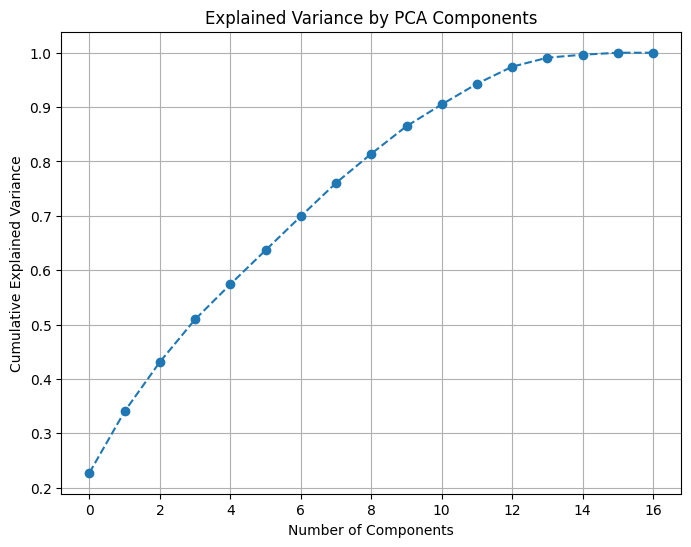

In [ ]:
pca_full = PCA()

# Fit PCA
pca_full.fit(X_scaled)

# Plot the cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), marker='o', linestyle='--')
plt.title('Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [ ]:
pca = PCA(n_components=15)
X_pca = pca.fit_transform(X_scaled)

# Check the explained variance ratio
print(pca.explained_variance_ratio_)

# Print the cumulative variance explained by the components
print(f"Cumulative explained variance: {np.sum(pca.explained_variance_ratio_):.2f}")

[0.22753382 0.11300566 0.09080272 0.07829194 0.06444943 0.06272451
 0.06231631 0.06144747 0.05358654 0.05070359 0.03999425 0.03806013
 0.03137771 0.01657907 0.00546569]
Cumulative explained variance: 1.00


We were able to retain 90% Cumulative Explained Variance, while reducing from 16 components to 11.





#Machine Learning - Clustering

##K-Means
I have chosen K-Means as the first Model to implement because I would like to assign the amount of customer segments. K should be 5, because we want to find 5 perk segments, but I will be trying other variations incase two groups could share a perk.

In [ ]:
k = 10
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_scaled)

# Cluster labels
features_df['cluster'] = kmeans.labels_

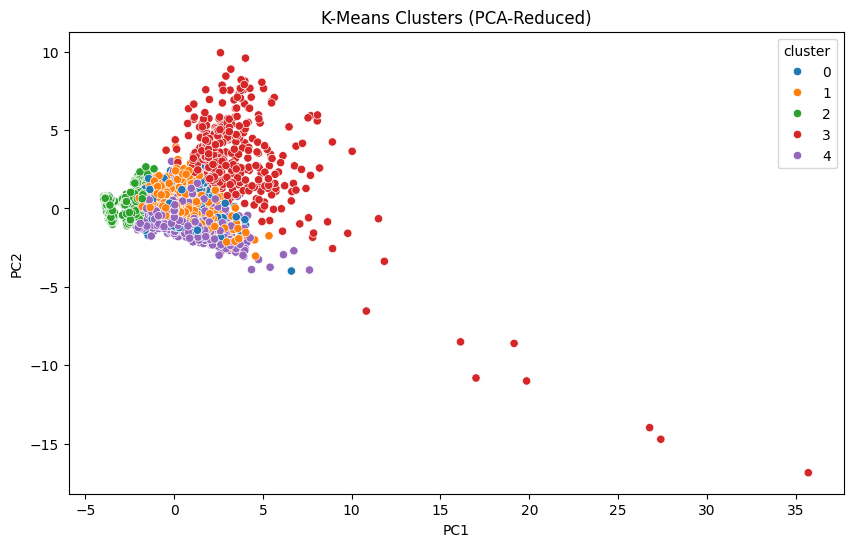

In [ ]:
plt.figure(figsize=(10, 6))
# Assuming X_pca has 13 components, selecting the first 2 for visualization
pca_df = pd.DataFrame(X_pca[:, :2], columns=['PC1', 'PC2']) # Select the first 2 components
pca_df['cluster'] = kmeans.labels_

sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster', palette='tab10')
plt.title("K-Means Clusters (PCA-Reduced)")
plt.show()

###Checking Silhouette Score
Closer to 1 = better, < 0.3 = weak

In [ ]:
score = silhouette_score(X_scaled, kmeans.labels_)
print(f"Silhouette Score: {score:.2f}")

Silhouette Score: 0.15


###Elbow Method to choose a better k value

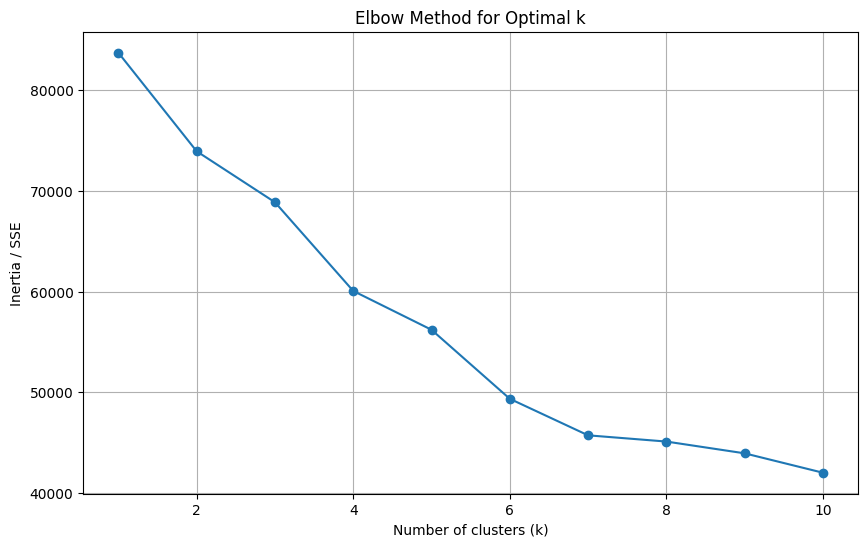

In [ ]:
sse = []
k_range = range(1, 11)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_pca)
    sse.append(km.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia / SSE')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

In [ ]:
k = 7
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_pca)

# Cluster labels
features_df['cluster'] = kmeans.labels_

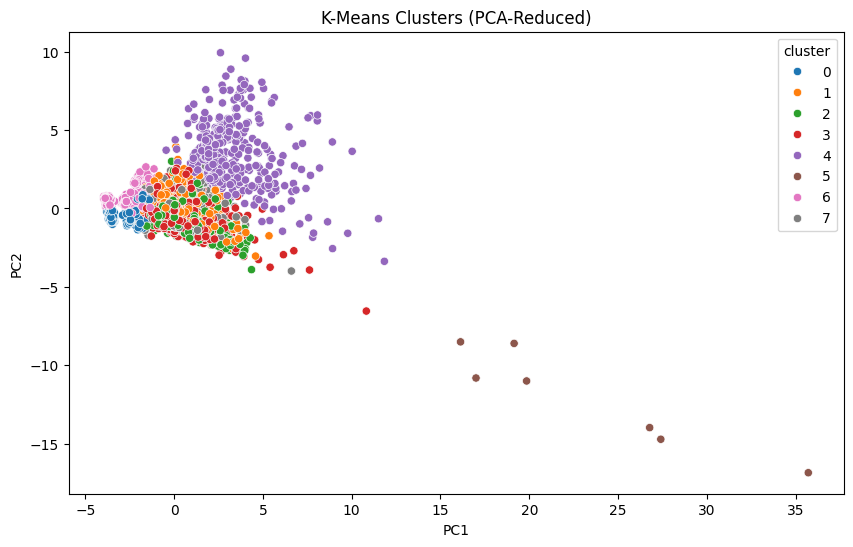

In [ ]:
plt.figure(figsize=(10, 6))
# Assuming X_pca has 13 components, selecting the first 2 for visualization
pca_df = pd.DataFrame(X_pca[:, :2], columns=['PC1', 'PC2']) # Select the first 2 components
pca_df['cluster'] = kmeans.labels_

sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster', palette='tab10')
plt.title("K-Means Clusters (PCA-Reduced)")
plt.show()

In [ ]:
score = silhouette_score(X_pca, kmeans.labels_)
print(f"Silhouette Score: {score:.2f}")

Silhouette Score: 0.16


Remove features clicks and sessions

##DBSCAN
Now I'm implementing DBSCAN because its effective for identifying clusters of varying shapes and handling noise.

In [ ]:
db = DBSCAN(eps=0.5, min_samples=5)
labels = db.fit_predict(X_scaled)

print("Silhouette (DBSCAN):", silhouette_score(X_scaled, labels))

Silhouette (DBSCAN): -0.3479065820800244


In [ ]:
n_noise = np.sum(labels == -1)
print(f"Number of noise points: {n_noise} out of {len(labels)}")

Number of noise points: 5420 out of 5782


In [ ]:
for eps in [2,3,5,7]:
    db = DBSCAN(eps=eps, min_samples=5)
    labels = db.fit_predict(X_scaled)
    if len(set(labels)) > 1 and len(set(labels)) < len(X_scaled):  # Avoid trivial all-in-one or all-noise
        score = silhouette_score(X_scaled, labels)
        print(f"eps={eps} → silhouette score: {score:.3f}, clusters: {len(set(labels))}")

eps=2 → silhouette score: 0.076, clusters: 41
eps=3 → silhouette score: 0.105, clusters: 4
eps=5 → silhouette score: 0.730, clusters: 2
eps=7 → silhouette score: 0.838, clusters: 2


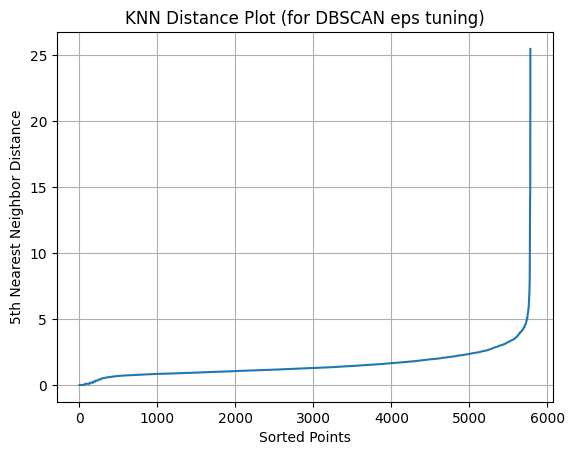

In [ ]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)

# Sort the distances and plot
distances = np.sort(distances[:, 4])  # 4th NN (because n_neighbors=5)
plt.plot(distances)
plt.title("KNN Distance Plot (for DBSCAN eps tuning)")
plt.xlabel("Sorted Points")
plt.ylabel("5th Nearest Neighbor Distance")
plt.grid(True)
plt.show()

Choosing ε and MinPts

Elbow Method

Silhouette Score

##Clustering Conclusion:

# Analyze the Clusters

Conduct Exploratory Data Analysis (EDA) to examine each segment independently. Identify their key traits - what makes each segment unique? How do they differ from one another? Use both numerical analysis and visualizations to uncover patterns. Finally, summarize your findings with clear conclusions based on your observations.